# Notes: You will have to:
  >1- Make a Copy of this notebook to edit it for your solutions;
  >
  >2- Upload on Gradescope: The `Colab Notebook edited with your solutions`, and a `pdf Report (Discussion questions)`.

# Question 1: MLP Implementation with Numpy

In this exercise, we will explore the construction of a multi-layer perceptron (MLP) by coding it from the ground up. We will develop a deep neural network step-by-step, beginning with a single neuron, progressing to a layer, and ultimately building the entire network. We will then train this network and evaulate on an interesting dataset and try to understand the workings in more details.

## Installing dependencies

In [18]:
# !pip install numpy scikit-learn matplotlib

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

## Q 1.1 (a): Activation Functions

In this question you will implement the softmax and ReLU activation functions and their derivatives. Both these functions help introduce non-linearity which gives neural network their capacity. We will implement these functions in the `ActivationFunction` class as static methods. You can access the method later using the following code:

```
# For softmax activation
ActivationFunction.softmax(x)

# For calucating the derivative of softmax function
ActivationFunction.softmax_derivative(x)

# For ReLU activation
ActivationFunction.relu(x)

# For calculating the derivative of ReLU function
ActivationFunction.relu_derivative(x)
```

In [20]:
class ActivationFunction:
    @staticmethod
    def softmax(x):
        """
        Compute the Softmax activation function.

        Args:
            x (np.array): Input values

        Returns:
            np.array: Softmax activation values
        """
        # Soustraire le max pour stabilité numérique (éviter overflow)
        exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))

        # Normaliser
        softmax = exp_x / np.sum(exp_x, axis=-1, keepdims=True)
        #print('Input : ', x,' Softmax :', softmax)
        return softmax


    @staticmethod
    def softmax_derivative(x):
        """
        Compute the derivative of the Softmax function.

        Args:
            x (np.array): Input values

        Returns:
            np.array: Derivative of Softmax function
        """
        s = ActivationFunction.softmax(x)
        return s * (1 - s) # This is the derivative for a single output softmax, not multiclass softmax.



    @staticmethod
    def relu(x):
        """
        Compute the ReLU activation function.

        Args:
            x (np.array or float): Input values

        Returns:
            np.array or float: ReLU activation values
        """
        # Use np.maximum which works for both scalars and arrays
        relu = np.maximum(0, x)
        return relu

    @staticmethod
    def relu_derivative(x):
        """
        Compute the derivative of the ReLU activation function.

        Args:
            x (np.array or float): Input values

        Returns:
            np.array or float: Derivative of ReLU function
        """
        # Ensure the output has the same shape as the input
        dev_relu = np.where(x > 0, 1, 0)
        return dev_relu

## Q 1.1 (b): Neuron Implementation

Neuron is the fundamental building block of MLP. A neuron simulates a biological neuron which can be activated or fired when responding to a stimulus. The equation of a neuron is as follow:

$$ f(x) = a(\mathbf{w} \cdot \mathbf{x} + b) $$

where inputs $\mathbf{x}$ and weights $\mathbf{w}$ are multidimensional vectors, bias $b$ is a scalar, $a(.)$ is an activation function.

**Note:** For the whole exercise you will be receiving inputs of batch size of 1.

In [21]:
class Neuron:
    def __init__(self, input_size, activation_function):
        """
        Initialize a neuron with random weights and bias.

        Args:
            input_size (int): Number of input features
            activation_function (function): Activation function to use
        """
        ### Write your code here ###
        self.activation_function = activation_function
        self.weights = np.random.randn(input_size) * np.sqrt(2.0 / input_size) #He initialization
        self.bias = 0.0 # Initalize bias to 0 as a size 1 array

    def activate(self, x):
        """
        Compute the activation of the neuron.

        Args:
            x (np.array): Input features

        Returns:
            float: Activation value
        """
        val = np.dot(np.asarray(self.weights), np.asarray(x)) + self.bias
        return self.activation_function(val)

## Q 1.1(c): Layer Implementation

Now we will compose a layer which consists of multiple neurons. Complete initializing the layer and compute the forward pass by sending the input through each neuron of the layer.

In [22]:
class Layer:
    def __init__(self, input_size, output_size, activation_function):
        """
        Initialize a layer of neurons.

        Args:
            input_size (int): Number of input features
            output_size (int): Number of neurons in the layer
            activation_function (function): Activation function to use
        """
        self.neurons = [Neuron(input_size, activation_function) for _ in range(output_size)]
        self.activation_function = activation_function

    def forward(self, x):
        """
        Compute the forward pass through the layer.

        Args:
            x (np.array): Input features

        Returns:
            np.array: Output of the layer
        """
        if self.activation_function == ActivationFunction.softmax:
            pre_activations = np.array([np.dot(neuron.weights, x) + neuron.bias for neuron in self.neurons])
            return ActivationFunction.softmax(pre_activations)
        else:
            # Pour les autres fonctions d'activation, on utilise activate de chaque neurone
            return np.array([neuron.activate(x) for neuron in self.neurons])

## Q 1.1(d) + 2 (a) to (d): Neural Network Construction

Now we have built all the building blocks required to build our neural network. Complete the implementations using the hints given in the code. There are additional functions that will be useful later. Do not modify these.

In [23]:
import numpy as np

class NeuralNetwork:
    def __init__(self, layer_sizes, hidden_dim, activation_function_hidden, activation_output):
        """
        Initialize a neural network with specified layer sizes.

        Args:
            layer_sizes (list): List of integers representing the size of each layer
            hiden_dim (int): Dimension of hidden layers
            activation_function_hidden (function): Activation function to use for hidden layers
            activation_output (function): Activation function to use for output layer
        """
        self.layers = []
        self.hidden_dim = hidden_dim
        self.activation_function_hidden = activation_function_hidden
        self.activation_output = activation_output
        # Input layer and hidden layers
        input_size = layer_sizes[0]
        for i in range(len(layer_sizes) - 2):
            self.layers.append(Layer(input_size, self.hidden_dim, self.activation_function_hidden))
            input_size = self.hidden_dim
        # Output layer
        self.layers.append(Layer(input_size, layer_sizes[-1], self.activation_output))
        self.loss_history = []


    def forward(self, x):
        """
        Compute the forward pass through the entire network.

        Args:
            x (np.array): Input features

        Returns:
            np.array: Output of the network
        """
        output_network = np.array(x)
        for layer in self.layers:
            output_network = layer.forward(output_network) # recursive call through the network
        return output_network

    def layer_backward(self, delta, layer_index, activations, zs):
        """
        Perform backpropagation for a single layer.

        Args:
            delta (np.array): Gradient of the loss with respect to the output of the current layer
            layer_index (int): Index of the current layer
            activations (list): List of activations from the forward pass
            zs (list): List of z values from the forward pass

        Returns:
            tuple: (delta for the previous layer, gradients for weights, gradients for biases)
        """
        layer = self.layers[layer_index]
        z = zs[layer_index]
        a_prev = activations[layer_index]

        # Calculate gradients for weights and biases for the current layer
        # Reshape delta and a_prev for matrix multiplication if needed
        if delta.ndim == 1:
            delta_reshaped = delta.reshape(-1, 1)
        else:
            delta_reshaped = delta

        if a_prev.ndim == 1:
            a_prev_reshaped = a_prev.reshape(1, -1)
        else:
            a_prev_reshaped = a_prev

        gradient_w = np.dot(delta_reshaped, a_prev_reshaped)
        gradient_b = delta # Bias gradient is the delta

        # Calculate delta for the previous layer
        delta_prev = None
        if layer_index > 0:
            # Form the weight matrix for the current layer
            layer_weights = np.array([neuron.weights for neuron in layer.neurons])
            delta_prev = np.dot(layer_weights.T, delta)

            # If it's a hidden layer, multiply delta by the derivative of the activation function of the previous layer's output (z)
            # This is done in the main backward loop after getting delta_prev

        return delta_prev, gradient_w, gradient_b


    def backward(self, x, y, learning_rate):
        """
        Perform backpropagation and update weights.

        Args:
            x (np.array): Input features
            y (np.array): True labels
            learning_rate (float): Learning rate for weight updates
        """
        # Forward pass - Store activations and z values for backward pass
        activations = [x]
        zs = []
        for layer in self.layers:
            # Calculate z for each neuron in the layer
            z_layer = []
            # The input to the layer is activations[-1]
            input_to_layer = activations[-1]
            for neuron in layer.neurons:
                z_layer.append(np.dot(np.array(neuron.weights), np.array(input_to_layer)) + neuron.bias)
            z = np.array(z_layer)
            zs.append(z)
            # Calculate activation for each neuron in the layer
            activation = layer.forward(input_to_layer) # layer.forward already applies the activation
            activations.append(activation)


        # Calculate initial delta for the output layer
        delta = self.loss_derivative(activations[-1], y) # dL/d(output)

        # Backward pass - Iterate backwards through the layers
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            z = zs[i]
            a_prev = activations[i] # Activation of the previous layer

            # If it's a hidden layer, we need to multiply the incoming delta by the derivative of the activation function
            if i < len(self.layers) - 1: # For hidden layers
                if self.activation_function_hidden == ActivationFunction.relu:
                    activation_derivative = ActivationFunction.relu_derivative(z)
                elif self.activation_function_hidden == ActivationFunction.softmax: # Softmax is typically not used in hidden layers
                    activation_derivative = ActivationFunction.softmax_derivative(z)
                else:
                    raise ValueError("Unsupported activation function for hidden layer")
                delta = delta * activation_derivative


            # Calculate gradients for weights and biases
            gradient_w = np.outer(delta, a_prev)
            gradient_b = delta


            # Calculate delta for the previous layer
            # delta_prev = dL/d(a_prev) = dL/dZ * dZ/d(a_prev)
            # dZ/d(a_prev) is the weight matrix of the current layer
            if i > 0:
                # Form the weight matrix for the current layer
                layer_weights = np.array([neuron.weights for neuron in layer.neurons])
                delta = np.dot(layer_weights.T, delta) # Propagate delta to the previous layer


        # Update weights and biases - Iterate forwards through the layers for updating
        # The gradients calculated in the backward pass are for each layer.
        # We need to apply these gradients to the corresponding layer's neurons.
        for i in range(len(self.layers)):
            layer = self.layers[i]
            # We need to recalculate the gradients for each layer since delta has changed
            activations = [x]
            zs = []
            for current_layer in self.layers:
                input_to_layer = activations[-1]
                z_layer = []
                for neuron in current_layer.neurons:
                    z_layer.append(np.dot(np.array(neuron.weights), np.array(input_to_layer)) + neuron.bias)
                z = np.array(z_layer)
                zs.append(z)
                activation = current_layer.forward(input_to_layer)
                activations.append(activation)

            # Calculate initial delta for the output layer
            delta = activations[-1] - y

            # Lists to store gradients
            gradients_w = [None] * len(self.layers)
            gradients_b = [None] * len(self.layers)

            # Backward pass to calculate and store gradients
            for i in reversed(range(len(self.layers))):
                layer = self.layers[i]
                z = zs[i]
                a_prev = activations[i]

                # If it's a hidden layer, apply derivative of the activation function
                if i < len(self.layers) - 1:
                    if self.activation_function_hidden == ActivationFunction.relu:
                        activation_derivative = ActivationFunction.relu_derivative(z)
                    elif self.activation_function_hidden == ActivationFunction.softmax:
                        activation_derivative = ActivationFunction.softmax_derivative(z)
                    else:
                        raise ValueError("Unsupported activation function for hidden layer")
                    delta = delta * activation_derivative


                # Calculate gradients for weights and biases
                gradient_w = np.outer(delta, a_prev)
                gradient_b = delta

                # Store gradients
                gradients_w[i] = gradient_w
                gradients_b[i] = gradient_b


                # Calculate delta for the previous layer
                if i > 0:
                    layer_weights = np.array([neuron.weights for neuron in layer.neurons])
                    delta = np.dot(layer_weights.T, delta)


            # Update weights and biases - Iterate forwards to apply stored gradients
            for i in range(len(self.layers)):
                layer = self.layers[i]
                gradient_w = gradients_w[i]
                gradient_b = gradients_b[i]

                for j, neuron in enumerate(layer.neurons):
                    # Update weights using the corresponding row of the gradient_w matrix
                    neuron.weights -= learning_rate * gradient_w[j, :]
                    # Update bias using the corresponding element of the gradient_b array
                    neuron.bias -= learning_rate * gradient_b[j]


    def train(self, X, y, epochs, learning_rate):
        """
        Train the neural network.

        Args:
            X (np.array): Training features
            y (np.array): Training labels
            epochs (int): Number of training epochs
            learning_rate (float): Learning rate for weight updates
        """
        for epoch in range(epochs):
            total_loss = 0
            for i in range(len(X)):
                # Calculate loss for the current sample
                output = np.array(self.forward(X[i]))
                output = self.forward(X[i])
                loss = self.compute_loss(output, y[i])
                total_loss += loss
                self.backward(X[i], y[i], learning_rate)

            average_loss = total_loss / len(X)
            self.loss_history.append(average_loss)

            if epoch % 1 == 0: # Print every epoch for a clearer view of training progress
                predictions = self.predict(X)
                accuracy = self.compute_accuracy(predictions, y) # Use compute_accuracy
                print(f"Epoch {epoch}, Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")

    def compute_loss(self, predictions, y_true):
        """
        Compute cross-entropy loss.

        Args:
            predictions (np.array): Model predictions
            y_true (np.array): True labels (one-hot encoded)

        Returns:
            float: Cross-entropy loss
        """
        # Avoid log(0) by adding a small constant
        loss = -np.sum(y_true * np.log(predictions + 1e-9)) / y_true.shape[0]
        return loss

    def loss_derivative(self, predictions, y_true):
        """
        Compute the derivative of the cross-entropy loss.

        Args:
            predictions (np.array): Model predictions
            y_true (np.array): True labels (one-hot encoded)

        Returns:
            np.array: Derivative of the loss
        """
        return predictions - y_true


    def compute_accuracy(self, predictions, y_true):
        """
        Compute accuracy of the model.

        Args:
            predictions (np.array): Model predictions
            y_true (np.array): True labels (one-hot encoded)

        Returns:
            float: Accuracy
        """
        # Convert one-hot encoded true labels to class indices
        y_true_indices = np.argmax(y_true, axis=1)
        # Get predicted class indices
        predicted_indices = np.argmax(predictions, axis=1)
        # Compare and compute accuracy
        accuracy = np.mean(predicted_indices == y_true_indices)
        return accuracy


    def predict(self, X):
        """
        Make predictions for a set of input features.

        Args:
            X (np.array): Input features

        Returns:
            np.array: Predictions
        """
        return np.array([self.forward(x) for x in X])

# Q 1.2(d): Training and Visualizing Neural Network

In the rest of the exercise we will use the components we built earlier to train a neural network and visualise the loss curve. To make things simple we will be building neural networks with only one hidden layer.

We will use the MNIST dataset for all our experiements which consists of 10 classes.


In [ ]:
# Uncomment the below code to create the dataset. And comment it when submitting to gradescope

#np.random.seed(42) # Do not change
# For easy data loading and processing, we're using torch here. You're not allowed to use torch for Neural Net components though.
def get_train_test_dataset():
    import torch
    from torchvision import datasets, transforms

    # Define a transform to convert images to tensors and normalize
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    # Load the MNIST dataset
    mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    # Take a subset of 1000 samples
    X = mnist_dataset.data[:1000].float() / 255.0  # Normalize pixel values to [0,1]
    y = mnist_dataset.targets[:1000]

    # Creat test / test split
    x_train, x_test = X[:800], X[800:]
    y_train, y_test = y[:800], y[800:]

    # to be completed
    print("Training set shape:", x_train.shape)
    print("Test set shape :", x_test.shape)

    return x_train, y_train, x_test, y_test

##Let's visualize a few samples

In [25]:
# Plot a few images

def visualize_mnist_samples(X, y, num_samples=9):
    """Visualize MNIST sample images"""
    plt.figure(figsize=(10, 8))
    for i in range(min(num_samples, len(X))):
        plt.subplot(3, 3, i + 1)
        # Reshape from flattened to 28x28 for visualization
        img = X[i].reshape(28, 28)
        plt.imshow(img, cmap='gray')
        plt.title(f"Label: {y[i]}")
        plt.axis('off')

    plt.suptitle('MNIST Sample Images')
    plt.tight_layout()
    plt.show()

Below you have been given the code to train your neural network. and visualize the decision boundry. Modify the hyperparameters to train and visualize the neural network and report your findings in the practical report. We will be testing our model on the training set. The `plot_decision_boundary` method takes the data created earlier and the neural network you trained to show the decision boundry.

In [26]:
def train_network(hidden_layer_size, hidden_dim, epochs, activation_hidden, activation_output, learning_rate):
    input_size, output_size = 28 * 28, 10
    layers = [input_size, hidden_layer_size, output_size]

    nn = NeuralNetwork(layers, hidden_dim, activation_hidden, activation_output)

    X_train, y_train, X_test, y_test = get_train_test_dataset()

    # --- Prepare training data ---
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    y_train_np = y_train.numpy()

    # One-hot encode labels
    y_train_onehot = np.eye(output_size)[y_train_np]

    # Train
    train_loss = nn.train(X_train_flat, y_train_onehot, epochs=epochs, learning_rate=learning_rate)

    # --- Evaluate on training data ---
    preds_train = nn.predict(X_train_flat)
    train_accuracy = np.mean(np.argmax(preds_train, axis=1) == y_train_np)

    # --- Evaluate on test data ---
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    y_test_np = y_test.numpy()
    preds_test = nn.predict(X_test_flat)
    test_accuracy = np.mean(np.argmax(preds_test, axis=1) == y_test_np)

    return nn, train_loss, train_accuracy, test_accuracy

In [27]:
# Write the code to train and visualize
# Consider commenting this out when submitting to gradescope

hidden_layer_size = 128
hidden_dim = 128
epochs = 20
activation_hidden = ActivationFunction.relu
activation_output = ActivationFunction.softmax
learning_rate = 0.001
nn, train_loss, train_accuracy, test_accuracy = train_network(hidden_layer_size, hidden_dim,  epochs, activation_hidden, activation_output, learning_rate)


Training set shape: torch.Size([800, 28, 28])
Test set shape : torch.Size([200, 28, 28])
Epoch 0, Loss: 0.1757, Accuracy: 0.7900
Epoch 1, Loss: 0.0975, Accuracy: 0.8588
Epoch 2, Loss: 0.0688, Accuracy: 0.8825
Epoch 3, Loss: 0.0550, Accuracy: 0.9025
Epoch 4, Loss: 0.0466, Accuracy: 0.9150
Epoch 5, Loss: 0.0408, Accuracy: 0.9213
Epoch 6, Loss: 0.0363, Accuracy: 0.9287
Epoch 7, Loss: 0.0328, Accuracy: 0.9413
Epoch 8, Loss: 0.0299, Accuracy: 0.9475
Epoch 9, Loss: 0.0274, Accuracy: 0.9525
Epoch 10, Loss: 0.0252, Accuracy: 0.9563
Epoch 11, Loss: 0.0232, Accuracy: 0.9613
Epoch 12, Loss: 0.0215, Accuracy: 0.9637
Epoch 13, Loss: 0.0200, Accuracy: 0.9663
Epoch 14, Loss: 0.0185, Accuracy: 0.9700
Epoch 15, Loss: 0.0173, Accuracy: 0.9750
Epoch 16, Loss: 0.0161, Accuracy: 0.9800
Epoch 17, Loss: 0.0150, Accuracy: 0.9800
Epoch 18, Loss: 0.0140, Accuracy: 0.9812
Epoch 19, Loss: 0.0131, Accuracy: 0.9838


# Q 1.3: Reporting and analysis
Analyze your trained model and present findings clearly as asked in the instruction PDF.

In [28]:
print("Train accuracy: ", train_accuracy)
print("Test accuracy: ", test_accuracy)

Train accuracy:  0.98375
Test accuracy:  0.875


# Training loss curve

In [29]:
# Plot the training loss across 20 epochs

def plot_loss_curve(train_loss):
  # Write your code here
  pass

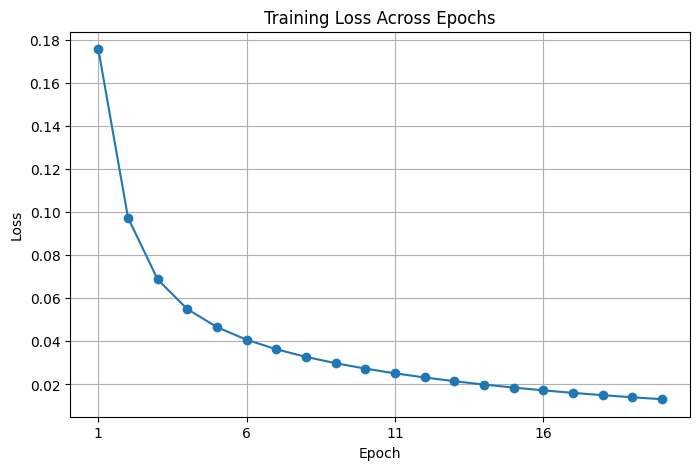

In [30]:
# Plot the training loss across 20 epochs

def plot_loss_curve(train_loss):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(train_loss) + 1), train_loss, marker='o')
    plt.title("Training Loss Across Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xticks(range(1, len(train_loss) + 1, 5))
    plt.grid(True)
    plt.show()

plot_loss_curve(nn.loss_history)

## Layer activation visualization

In [31]:
# ===== Latent Space Visualization =====
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import inspect # Import inspect for type checking

def get_penultimate_activations(nn, X_batch):
    """Get activations from the last hidden layer"""
    # Check if nn is an instance of the custom NeuralNetwork and has layers
    if not hasattr(nn, 'layers') or not isinstance(nn.layers, list):
         print(f"Error: Expected nn to have a 'layers' attribute which is a list, but got type {type(nn)} with layers: {getattr(nn, 'layers', 'N/A')}")
         return np.array([]) # Return empty array or raise error

    # Process each sample individually
    activations_list = []
    for x in X_batch:
        activations = x
        # Iterate through layers, excluding the last one
        for i in range(len(nn.layers) - 1): # Iterate through all layers except the output layer
            layer = nn.layers[i]
            # The forward pass in the custom Layer class expects a single input sample
            # Ensure the layer is a custom Layer instance before calling forward
            if not isinstance(layer, Layer):
                print(f"Error: Expected layer at index {i} to be a custom Layer instance, but got type {type(layer)}")
                return np.array([]) # Return empty array or raise error

            activations = layer.forward(activations)
        activations_list.append(activations)
    return np.array(activations_list)

def visualize_activations(nn, X_test, y_test, digits=(3, 8), method='PCA'):
    """Visualize layer activations using PCA or t-SNE"""
    # Get activations from penultimate layer
    Z = get_penultimate_activations(nn, X_test)

    # If Z is empty, skip visualization
    if Z.size == 0:
        print("Skipping visualization due to error in getting activations.")
        return None

    # Apply dimensionality reduction
    if method == 'PCA':
        reducer = PCA(n_components=2)
    else:  # t-SNE
        reducer = TSNE(n_components=2, random_state=42)

    Z_2d = reducer.fit_transform(Z)

    # Plot visualization
    plt.figure(figsize=(12, 5))

    # Plot 2: Focus on specific digits
    plt.subplot(1, 2, 2)
    mask1 = y_test == digits[0]
    mask2 = y_test == digits[1]

    # write your code here
    plt.scatter(Z_2d[mask1, 0], Z_2d[mask1, 1], label=f'Digit {digits[0]}', alpha=0.5)
    plt.scatter(Z_2d[mask2, 0], Z_2d[mask2, 1], label=f'Digit {digits[1]}', alpha=0.5)
    plt.legend()

    plt.title(f'Latent Space: Digits {digits[0]} vs {digits[1]}')

    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.tight_layout()
    plt.show()

    return Z_2d

Training set shape: torch.Size([800, 28, 28])
Test set shape : torch.Size([200, 28, 28])


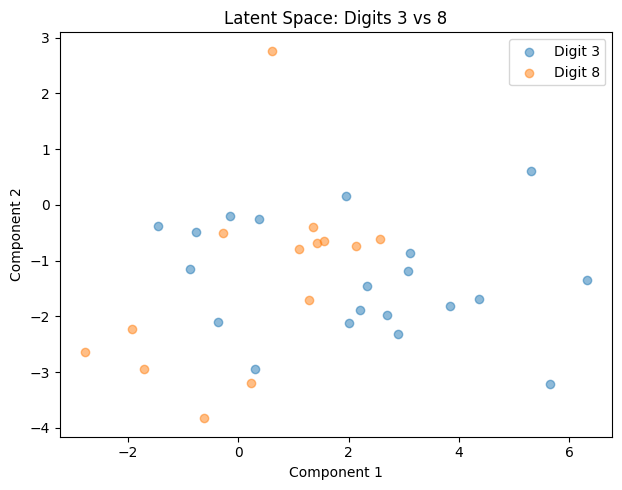

/Users/katherinedemers/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/katherinedemers/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/katherinedemers/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/katherinedemers/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/katherinedemers/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/katherinedemers/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: invalid val

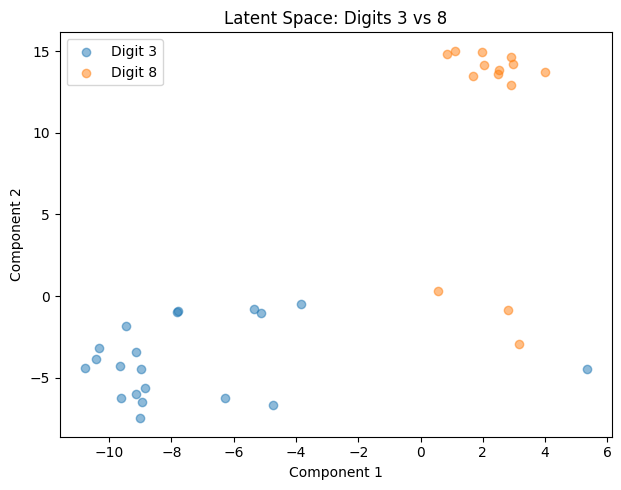

array([[ 3.88956428e+00,  6.91786098e+00],
       [ 6.86350060e+00, -2.98415303e-01],
       [ 1.07973204e+01, -3.95391703e+00],
       [-3.43516827e+00,  5.75406885e+00],
       [ 7.95799160e+00,  2.22716594e+00],
       [-7.75725603e+00, -4.58890820e+00],
       [ 4.25247622e+00,  6.88460875e+00],
       [ 6.53669119e+00, -5.22614956e-01],
       [-3.84128881e+00, -4.71633494e-01],
       [-3.82599980e-01, -3.72861218e+00],
       [ 1.14785042e+01, -3.94742846e+00],
       [-8.95514965e+00, -6.50269365e+00],
       [ 4.00802803e+00,  4.90659714e+00],
       [-3.90227938e+00,  3.58743691e+00],
       [-1.40193522e+00, -7.34414053e+00],
       [-7.28015280e+00, -5.60879707e+00],
       [ 1.00788050e+01, -4.59977007e+00],
       [ 1.11580467e+00,  1.50383720e+01],
       [-2.98335344e-01, -1.30537910e+01],
       [-3.60622811e+00,  7.56538820e+00],
       [-3.95254165e-01,  7.17488194e+00],
       [ 9.70186591e-01, -4.94446230e+00],
       [ 1.14313853e+00,  2.45318890e+00],
       [ 2.

In [32]:
# Get test dataset to use for visualization
_, _, X_test, y_test = get_train_test_dataset()
X_test_flat = X_test.reshape(X_test.shape[0], -1)
y_test_np = y_test.numpy()

# Visualize activations for digits 3 and 8 using PCA
visualize_activations(nn, X_test_flat, y_test_np, digits=(3, 8), method='PCA')

# Visualize activations for digits 3 and 8 using t-SNE
visualize_activations(nn, X_test_flat, y_test_np, digits=(3, 8), method='TSNE')

## Hyperparemeter discussion
You can try out changing hypermaters (leraning rate, hidden dim, num. of hidden layers) and report how that impact training loss, train/test accuracy

## Question 2: Convolutional Neural Network (using PyTorch)

### Setup

In [33]:

import math, random, time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Hyperparameters
learning_rate = 1e-3  # or 3e-4
num_epochs = 30
batch_size = 64
num_classes = 10
validation_split = 0.2


Device: cpu


In [34]:
class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias   = nn.Parameter(torch.Tensor(out_features)) if bias else None
        self.reset_parameters()
        self._cache_x = None

    def reset_parameters(self):
        # Kaiming Uniform (fixed by assignment)
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, x):
        """
        TODO: Compute y = x W^T + b.
        Hints:
          • Use a batched matmul pattern that preserves leading batch dims.
          • Add bias if present.
        """
        self._cache_x = x
        "WRITE YOUR CODE HERE"
        forward = x @ self.weight.T
        if self.bias is not None:
            forward += self.bias
        return forward

    def backward(self, grad_output):
        """
        TODO: Compute gradients wrt input, weight, bias.
        param grad_output: gradient wrt output
        Return: (grad_input, grad_weight, grad_bias)
        """
        x = self._cache_x

        # Ensure grad_output has the same dtype as weights for matrix multiplication
        grad_input  = grad_output.to(self.weight.dtype) @ self.weight
        grad_weight = grad_output.transpose(0, 1) @ x.to(grad_output.dtype) # Ensure x is also compatible for grad_weight calculation
        grad_bias = grad_output.sum(dim=0) if self.bias is not None else None

        return grad_input, grad_weight, grad_bias


## Part 1: Implementing the CNN

You will build the core components of the CNN, with **both** forward and backward passes.

### (a) Fully Connected Layer
Implement a linear layer:
y = xW^T + b

### (b) Convolution Layer
Implement a 2D convolution layer with basic operations

In [35]:
class CustomConv2D(nn.Module):
    """
    2D Convolution (k x k) with manual forward/backward using unfold/fold.

    Shapes and symbols:
      x: input of shape (N, C_in, H, W)
        N = batch size, C_in = input channels, H/W = spatial dims: Heigth/Width
      w: weights of shape (C_out, C_in, k, k), with C_out = output channels
      b: bias of shape (C_out,)
      k: kernel_size
      s: stride
      p: padding

      H_out = floor((H + 2*p - k)/s) + 1
      W_out = floor((W + 2*p - k)/s) + 1
      L = H_out * W_out   # number of sliding-window locations per feature map
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.weight = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size))
        self.bias   = nn.Parameter(torch.Tensor(out_channels))
        self.reset_parameters()
        self._cache_x = None

    def reset_parameters(self):
        # Kaiming Uniform (fixed)
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, x):
        """
        TODO: Compute conv output using F.unfold and a batched dot-product.
        Hints:
          • Unfold to shape (N, C_in*k*k, L) where L is number of locations.
          • Reshape weights to (C_out, C_in*k*k).
          • Add bias per output channel.
          • Reshape to (N, C_out, H_out, W_out).
        """
        self._cache_x = x
        unfold = F.unfold(x, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        weights_reshape = self.weight.view(self.out_channels, -1)

        # Perform batched matrix multiplication: (N, C_in*k*k, L).transpose(1, 2) @ (C_in*k*k, C_out).transpose(0, 1)
        # The result will be (N, L, C_out)
        output = unfold.transpose(1, 2) @ weights_reshape.T

        # Reshape the output to (N, C_out, H_out, W_out)
        N, L, C_out = output.shape
        H_in, W_in = x.shape[2:]
        H_out = (H_in + 2 * self.padding - self.kernel_size) // self.stride + 1
        W_out = (W_in + 2 * self.padding - self.kernel_size) // self.stride + 1

        output = output.view(N, H_out, W_out, C_out).permute(0, 3, 1, 2)

        if self.bias is not None:
            output += self.bias.view(1, -1, 1, 1)

        return output

    def backward(self, grad_output):
        """
        TODO: Compute gradients wrt input, weight, bias.
        Hints:
          • Reuse unfolded patches.
          • grad_weight: correlate grad_output with unfolded input patches.
          • grad_bias: sum grad_output over batch and spatial locations.
          • grad_input: map grads back via an unfolded representation and fold.
        Return: (grad_input, grad_weight, grad_bias)
        """
        x = self._cache_x

        # Calculate grad_bias: sum grad_output over batch and spatial dimensions
        grad_bias = grad_output.sum(dim=(0, 2, 3)) if self.bias is not None else None

        # Reshape grad_output for matrix multiplication with unfolded input
        N, C_out, H_out, W_out = grad_output.shape
        grad_output_reshaped = grad_output.permute(0, 2, 3, 1).reshape(N, H_out * W_out, C_out) # (N, L, C_out)

        # Calculate grad_weight: (C_out, C_in*k*k)
        unfold_x = F.unfold(x, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding) # (N, C_in*k*k, L)
        # grad_output_reshaped: (N, L, C_out) -> permute to (N, C_out, L)
        grad_output_perm = grad_output_reshaped.permute(0, 2, 1)  # (N, C_out, L)
        # Use einsum to sum over batch (n) and spatial locations (l), result shape (C_out, C_in*k*k)
        grad_weight = torch.einsum('ncl,nml->cm', grad_output_perm, unfold_x).view(self.weight.shape)


        # Calculate grad_input: (N, C_in, H, W)
        grad_unfold = grad_output_reshaped @ self.weight.view(self.out_channels, -1) # (N, L, C_in*k*k)
        grad_unfold = grad_unfold.transpose(1, 2) # (N, C_in*k*k, L)

        # Fold back to image space
        grad_input = F.fold(grad_unfold, output_size=x.shape[2:], kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)

        return grad_input, grad_weight, grad_bias

### (c) Max Pooling Layer
Implement a max pooling layer

In [36]:
class CustomMaxPool2D(nn.Module):
    """
    Max Pooling (k x k) with manual forward/backward using unfold/fold.

    Shapes and symbols:
      x: input of shape (N, C, H, W)
        N = batch size, C = channels, H/W = spatial dims: Height, Width
      k: kernel_size (pool window is k x k)
      s: stride
      p: padding

      H_out = floor((H + 2*p - k)/s) + 1
      W_out = floor((W + 2*p - k)/s) + 1
      L = H_out * W_out   # number of sliding-window locations per feature map
    """
    def __init__(self, kernel_size, stride=None, padding=0):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride if stride is not None else kernel_size
        self.padding = padding
        self._cache_shape = None
        self._cache_indices = None

    def forward(self, x):
        """
        TODO: Max over k*k windows.
        Hints:
          • Unfold x → patches of shape (N, C*k*k, L)
          • View → (N, C, k*k, L)
          • Take max over the k*k dimension → outputs (N, C, L) and argmax indices (N, C, L)
          • Cache argmax indices + shapes.
          • Reshape output reshaped to (N, C, H_out, W_out).
        """
        unfold_x = F.unfold(x, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        # reshape to (N, C, k*k, L) where L = number of sliding windows
        view_x = unfold_x.view(x.shape[0], x.shape[1], self.kernel_size * self.kernel_size, unfold_x.shape[2])
        # take max over the flattened k*k dimension -> (N, C, L)
        max_x, self._cache_indices = view_x.max(dim=2)
        self._cache_shape = x.shape

        N, C, L = max_x.shape
        H_in, W_in = x.shape[2:]
        H_out = (H_in + 2 * self.padding - self.kernel_size) // self.stride + 1
        W_out = (W_in + 2 * self.padding - self.kernel_size) // self.stride + 1
        output = max_x.view(N, C, H_out, W_out)

        return output

    def backward(self, grad_output):
        """
        TODO: Implement max pooling backward (route grads to maxima only).
        Inputs: grad_output: (N, C, H_out, W_out)
        Hints:
          • Make zeros tensor grad_unfold of shape (N, C, k*k, L)
          • Scatter grad_output into grad_unfold at the argmax positions from forward
          • View grad_unfold → (N, C*k*k, L)
          • Fold back to image space → grad_input of shape (N, C, H, W)

        Return: grad_input(N, C, H, W)
        """
        grad_unfold = torch.zeros(self._cache_shape, device=grad_output.device)
        # Reshape grad_output to (N, C, L) to match _cache_indices shape for scattering
        N, C, H_out, W_out = grad_output.shape
        grad_output_reshaped = grad_output.view(N, C, -1) # Reshape to (N, C, L)

        # Scatter the gradients to the locations of the maximum values
        N, C, H_in, W_in = self._cache_shape
        L = (H_in + 2 * self.padding - self.kernel_size) // self.stride + 1
        L *= (W_in + 2 * self.padding - self.kernel_size) // self.stride + 1
        zeros_for_scatter = torch.zeros(N, C, self.kernel_size * self.kernel_size, L, device=grad_output.device)
        scattered_grad = zeros_for_scatter.scatter_(2, self._cache_indices.unsqueeze(2), grad_output_reshaped.unsqueeze(2))

        # Reshape the scattered gradients back to (N, C*k*k, L)
        grad_unfold = scattered_grad.view(N, C * self.kernel_size * self.kernel_size, L)

        # Fold back to image space
        grad_input = F.fold(grad_unfold, output_size=(H_in, W_in), kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)

        return grad_input

### (d) Cross-Entropy Loss [2 points]
Implement cross-entropy loss with numerical stability

In [37]:
class CustomCrossEntropyLoss(nn.Module):
    def __init__(self, reduction="mean"):
        super().__init__()
        self.reduction = reduction
        self._cache = None

    def forward(self, logits, targets):
        """
        TODO: Compute numerically-stable cross-entropy.
        Hints:
          • Subtract max per row before exponentiation.
          • Convert to probabilities; pick class probs at targets.
          • Apply -log(...) and reduction (mean by default).
          • Cache what's needed for backward.
        """
        max_per_row, _ = logits.max(dim=1, keepdim=True)
        logits_shifted = logits - max_per_row
        probs = torch.exp(logits_shifted) / torch.exp(logits_shifted).sum(dim=1, keepdims=True)
        class_probs = probs[torch.arange(logits.shape[0]), targets]
        loss = -torch.log(class_probs)
        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()
        self._cache = probs # Cache probs for backward if logits/targets are not passed
        return loss

    def backward(self, logits, targets):
        """
        TODO: Compute gradient w.r.t. logits.
        Hints:
          • If `logits` and `targets` are provided, recompute softmax probs stably.
            Otherwise, use cached probs/targets from forward().
          • Divide by batch size if reduction == 'mean'.
        Return: grad_logits
        """
        # Recompute probs for backward pass to ensure it's part of the current computation graph
        max_per_row, _ = logits.max(dim=1, keepdim=True)
        logits_shifted = logits - max_per_row
        probs = torch.exp(logits_shifted) / torch.exp(logits_shifted).sum(dim=1, keepdims=True)

        # Compute the gradient of the loss with respect to the logits
        grad_logits = probs.clone() # Create a clone to avoid modifying probs in-place
        grad_logits[torch.arange(logits.shape[0]), targets] -= 1

        if self.reduction == "mean":
            grad_logits /= logits.shape[0]

        return grad_logits


## Part 2: Training the CNN

Build and train the CNN for MNIST using **your custom layers**.

### (a) Training pipeline code
Address `TODO` in:
1. **Backward pass section** — explicit chaining with your `backward()` methods.  
2. **Parameter updates section** — manual updates using SGD-style with `torch.no_grad()`.

### (b) Training and experiments
Train your CNN on MNIST and run the following configurations:
1. **Activations (2):** ReLU, Tanh.  
2. **Learning rates (2):** 1e-3, 3e-4.

Use consistent hyperparameters across runs. This yields 4 configurations.


In [38]:
def get_activation(name):
    if name.lower() == "relu":
        return F.relu, lambda z: (z > 0).to(z.dtype)
    elif name.lower() == "tanh":
        return torch.tanh, lambda z: 1 - torch.tanh(z)**2
    else:
        raise ValueError("Unknown activation: " + name)

class CNN(nn.Module):
    def __init__(self, activation_name="relu", num_classes=10):
        super().__init__()
        self.ACT, self.ACT_PRIME = get_activation(activation_name)

        self.conv1 = CustomConv2D(1, 32, 5)
        self.conv2 = CustomConv2D(32, 64, 3) # Reduced kernel size to 3
        self.max1  = CustomMaxPool2D(2, stride=2)
        self.max2  = CustomMaxPool2D(2, stride=2)

        # Calculate the output size after conv and pooling layers to determine the input size for the first FC layer
        # We can do a dummy forward pass with a single sample to get the shape
        dummy_input = torch.zeros(1, 1, 28, 28)
        dummy_output = self.max2(self.ACT(self.conv2(self.max1(self.ACT(self.conv1(dummy_input))))))
        fc1_input_size = dummy_output.numel()

        self.fc1   = CustomLinear(fc1_input_size, 512)
        self.fc2   = CustomLinear(512, num_classes)

        self.criterion = CustomCrossEntropyLoss()

    def forward(self, x):
        # print(f"Input shape: {x.shape}") # Commented out for cleaner output
        z1 = self.conv1(x)
        # print(f"conv1 output shape: {z1.shape}") # Commented out for cleaner output
        a1 = self.ACT(z1)
        # print(f"a1 shape: {a1.shape}") # Commented out for cleaner output
        p1 = self.max1(a1)
        # print(f"max1 output shape: {p1.shape}") # Commented out for cleaner output

        z2 = self.conv2(p1)
        # print(f"conv2 output shape: {z2.shape}") # Commented out for cleaner output
        a2 = self.ACT(z2)
        # print(f"a2 shape: {a2.shape}") # Commented out for cleaner output
        p2 = self.max2(a2)
        # print(f"max2 output shape: {p2.shape}") # Commented out for cleaner output

        flat = torch.flatten(p2, start_dim=1)
        # print(f"flattened shape: {flat.shape}") # Commented out for cleaner output
        z3 = self.fc1(flat)
        # print(f"fc1 output shape: {z3.shape}") # Commented out for cleaner output
        a3 = self.ACT(z3)
        # print(f"a3 shape: {a3.shape}") # Commented out for cleaner output
        logits = self.fc2(a3)
        # print(f"logits shape: {logits.shape}") # Commented out for cleaner output

        # caches needed for manual backward
        caches = (z1, a1, p1, z2, a2, p2, z3, a3)
        return logits, caches

### Data (MNIST)

In [39]:

full_train = datasets.MNIST(root="./data_CNN", train=True, download=True, transform=ToTensor())
test_ds    = datasets.MNIST(root="./data_CNN", train=False, download=True, transform=ToTensor())

train_size = int((1 - validation_split) * len(full_train))
val_size   = len(full_train) - train_size
train_ds, val_ds = random_split(full_train, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print(f"Train/Val/Test sizes: {len(train_ds)}/{len(val_ds)}/{len(test_ds)}")



Train/Val/Test sizes: 48000/12000/10000


### Utilities

In [40]:

@torch.no_grad()
def accuracy_from_logits(logits, labels):
    return (logits.argmax(dim=1) == labels).float().mean().item()

def sgd_update_(param, grad, lr):
    param -= lr * grad
    return param



### Training Pipeline code
Address the TODOs in the code below
> - Complete the BACKWARD PASS (explicit chaining with your `.backward` methods).
> - Uncomment the PARAMETER UPDATES (manual SGD with no_grad)


In [41]:
def train_one_config(activation_name="relu", epochs=num_epochs, lr=learning_rate, num_classes=num_classes, debug_batches=0):
    model = CNN(activation_name=activation_name, num_classes=num_classes).to(device)
    criterion = model.criterion

    train_losses, val_losses = [], []
    train_accs,   val_accs   = [], []

    for epoch in range(epochs):
        model.train()
        total_train_loss, total_train_correct, total_train_examples = 0.0, 0, 0

        for batch_idx, (xb, yb) in enumerate(train_loader):
            xb, yb = xb.to(device), yb.to(device)

            # ---------- Forward ----------
            logits, caches = model(xb)
            loss = criterion(logits, yb)

            # Unpack caches (pre/post activations)
            z1, a1, p1, z2, a2, p2, z3, a3 = caches # Corrected unpacking to match the 8 cached values

            # ==========================================================================
            # BACKWARD PASS (explicit chaining with your .backward methods)
            # TODO: Implement the manual chain below and produce gradients with names:
            #       grad_fc2_w, grad_fc2_b, grad_fc1_w, grad_fc1_b,
            #       grad_conv2_w, grad_conv2_b, grad_conv1_w, grad_conv1_b
            #
            # Hints:
            #   1- Check PARAMETER UPDATES codes below for ideas and variable names
            #   2- Chain in the following way:
            #       - dL/dlogits from Cross-Entropy Loss
            #       - FC2 backward
            #       - Activation after FC1
            #       - FC1 backward
            #       - Reshape to feature map
            #       - MaxPool2 backward
            #       - Activation after Conv2
            #       - Conv2 backward
            #       - MaxPool1 backward
            #       - Activation after Conv1
            #       - Conv1 backward
            grad_output = criterion.backward(logits=logits, targets=yb)

            # Backpropagate through FC2
            grad_fc2_input, grad_fc2_w, grad_fc2_b = model.fc2.backward(grad_output=grad_output)

            # Backpropagate through Activation after FC1
            grad_activation3 = grad_fc2_input * model.ACT_PRIME(z3) # Apply derivative of activation function

            # Backpropagate through FC1
            grad_fc1_input, grad_fc1_w, grad_fc1_b = model.fc1.backward(grad_output=grad_activation3)

            # Reshape gradient from FC1 input to match the shape before flattening (N, C, H, W)
            # Infer spatial dims from the flattened size instead of hardcoding.
            N = grad_fc1_input.shape[0]
            C_flat = grad_fc1_input.shape[1]
            expected_C = 64
            if C_flat % expected_C != 0:
                raise RuntimeError(f"Unexpected flattened channel size {C_flat} (not divisible by {expected_C})")
            spatial = C_flat // expected_C
            k = int(math.sqrt(spatial))
            if k * k != spatial:
                raise RuntimeError(f"Flattened spatial size {spatial} is not a perfect square (got sqrt {math.sqrt(spatial)})")
            grad_fc1_input_reshaped = grad_fc1_input.view(N, expected_C, k, k)

            # Backpropagate through MaxPool2
            grad_max2_input = model.max2.backward(grad_output=grad_fc1_input_reshaped)

            # Backpropagate through Activation after Conv2
            grad_activation2 = grad_max2_input * model.ACT_PRIME(z2) # Apply derivative of activation function

            # Backpropagate through Conv2
            grad_conv2_input, grad_conv2_w, grad_conv2_b = model.conv2.backward(grad_output=grad_activation2)

            # Backpropagate through MaxPool1
            grad_max1_input = model.max1.backward(grad_output=grad_conv2_input)

            # Backpropagate through Activation after Conv1
            grad_activation1 = grad_max1_input * model.ACT_PRIME(z1) # Apply derivative of activation function

            # Backpropagate through Conv1
            grad_conv1_input, grad_conv1_w, grad_conv1_b = model.conv1.backward(grad_output=grad_activation1)


            # ===========================================
            # PARAMETER UPDATES (manual SGD with no_grad)
            # TODO: UNCOMMENT THE CODES BELOW, DO NOT CHANGE
            # ===========================================
            with torch.no_grad():
                # FC2
                model.fc2.weight.copy_(sgd_update_(model.fc2.weight, grad_fc2_w, lr))
                if model.fc2.bias is not None:
                    model.fc2.bias.copy_(sgd_update_(model.fc2.bias, grad_fc2_b, lr))
                # FC1
                model.fc1.weight.copy_(sgd_update_(model.fc1.weight, grad_fc1_w, lr))
                if model.fc1.bias is not None:
                    model.fc1.bias.copy_(sgd_update_(model.fc1.bias, grad_fc1_b, lr))
                # Conv2
                model.conv2.weight.copy_(sgd_update_(model.conv2.weight, grad_conv2_w, lr))
                model.conv2.bias.copy_(sgd_update_(model.conv2.bias, grad_conv2_b, lr))
                # Conv1
                model.conv1.weight.copy_(sgd_update_(model.conv1.weight, grad_conv1_w, lr))
                model.conv1.bias.copy_(sgd_update_(model.conv1.bias, grad_conv1_b, lr))


            # ---------- Train metrics ----------
            with torch.no_grad():
                total_train_loss += loss.item()
                total_train_examples += yb.size(0)
                total_train_correct += (logits.argmax(1) == yb).sum().item()
            # stop early when debugging small number of batches
            if debug_batches > 0 and batch_idx + 1 >= debug_batches:
                break

        # If debug_batches is set, we only processed debug_batches per epoch so adjust divisor
        effective_train_batches = debug_batches if debug_batches > 0 else len(train_loader)
        train_losses.append(total_train_loss / effective_train_batches)
        # compute train accuracy as fraction of examples processed
        train_accs.append(total_train_correct / (effective_train_batches * batch_size))

        # ---------- Validation ----------
        model.eval()
        val_loss_sum, val_correct, val_examples = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits, _ = model(xb)
                loss = criterion(logits, yb)
                val_loss_sum += loss.item()
                val_examples += yb.size(0)
                val_correct += (logits.argmax(1) == yb).sum().item()

        val_losses.append(val_loss_sum / len(val_loader))
        val_accs.append(val_correct / val_examples)

        print(f"Epoch {epoch+1:02d} | "
            f"Train Loss {train_losses[-1]:.4f}  Acc {train_accs[-1]*100:.2f}% | "
            f"Val Loss {val_losses[-1]:.4f}  Acc {val_accs[-1]*100:.2f}%")

    # ---------- Test ----------
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits, _ = model(xb)
            test_correct += (logits.argmax(1) == yb).sum().item()
            test_total += yb.size(0)
    test_acc = 100.0 * test_correct / test_total
    print(f"Test Accuracy: {test_acc:.2f}%")

    return {
        "train_loss": train_losses, "val_loss": val_losses,
        "train_acc": train_accs,   "val_acc": val_accs,
        "test_acc": test_acc
    }

### Training, and experiments
Train your CNN on MNIST and run the following configurations:
1. **Activations (2):** ReLU, Tanh.  
2. **Learning rates (2):** 1e-3, 3e-4.

Use consistent hyperparameters across runs. This yields 4 configurations:
- ReLU / LR = 1e-3
- ReLU / LR = 3e-4
- Tanh / LR = 1e-3
- Tanh / LR = 3e-4

In [42]:
# Training, and experiments : 4 configurations in total
activ_relu = "relu"
activ_tanh = "tanh"
lr_1e3 = 1e-3
lr_3e4 = 3e-4

print("Training with ReLU and LR = 1e-3")
results_relu_1e3 = train_one_config(activation_name=activ_relu, lr=lr_1e3)

print("\nTraining with ReLU and LR = 3e-4")
results_relu_3e4 = train_one_config(activation_name=activ_relu, lr=lr_3e4)

print("\nTraining with Tanh and LR = 1e-3")
results_tanh_1e3 = train_one_config(activation_name=activ_tanh, lr=lr_1e3)

print("\nTraining with Tanh and LR = 3e-4")
results_tanh_3e4 = train_one_config(activation_name=activ_tanh, lr=lr_3e4)

Training with ReLU and LR = 1e-3
Epoch 01 | Train Loss 2.2829  Acc 26.15% | Val Loss 2.2601  Acc 37.62%
Epoch 02 | Train Loss 2.2251  Acc 46.02% | Val Loss 2.1758  Acc 52.00%
Epoch 03 | Train Loss 2.0676  Acc 59.00% | Val Loss 1.8969  Acc 66.86%
Epoch 04 | Train Loss 1.5450  Acc 70.62% | Val Loss 1.1412  Acc 75.86%
Epoch 05 | Train Loss 0.8631  Acc 79.25% | Val Loss 0.6874  Acc 81.94%
Epoch 06 | Train Loss 0.5913  Acc 84.12% | Val Loss 0.5377  Acc 85.42%
Epoch 07 | Train Loss 0.4881  Acc 86.35% | Val Loss 0.4660  Acc 87.00%
Epoch 08 | Train Loss 0.4322  Acc 87.77% | Val Loss 0.4233  Acc 87.82%
Epoch 09 | Train Loss 0.3954  Acc 88.62% | Val Loss 0.3938  Acc 88.68%
Epoch 10 | Train Loss 0.3686  Acc 89.16% | Val Loss 0.3705  Acc 89.29%
Epoch 11 | Train Loss 0.3481  Acc 89.73% | Val Loss 0.3547  Acc 89.68%
Epoch 12 | Train Loss 0.3301  Acc 90.25% | Val Loss 0.3354  Acc 90.17%
Epoch 13 | Train Loss 0.3149  Acc 90.61% | Val Loss 0.3216  Acc 90.74%
Epoch 14 | Train Loss 0.3007  Acc 90.98% | V


## Part 3: Results and Discussions

1. **Plots:** Submit clear plots of training and validation **accuracy** and **loss** for each configuration. In addition, include the **test-set accuracy** on these plots. **Discuss results for each configuration**.


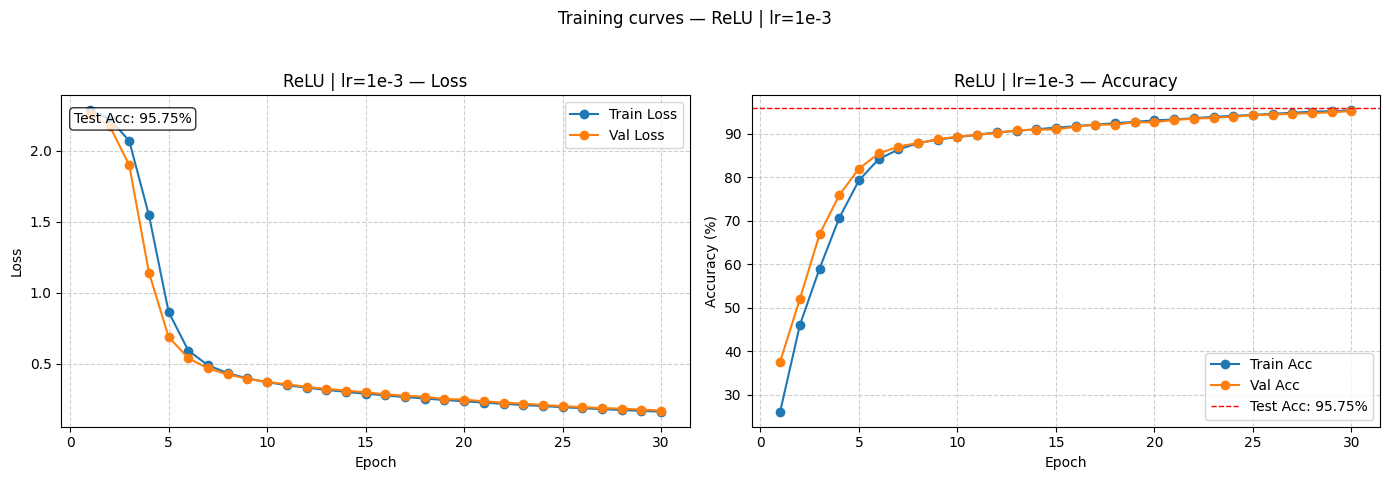

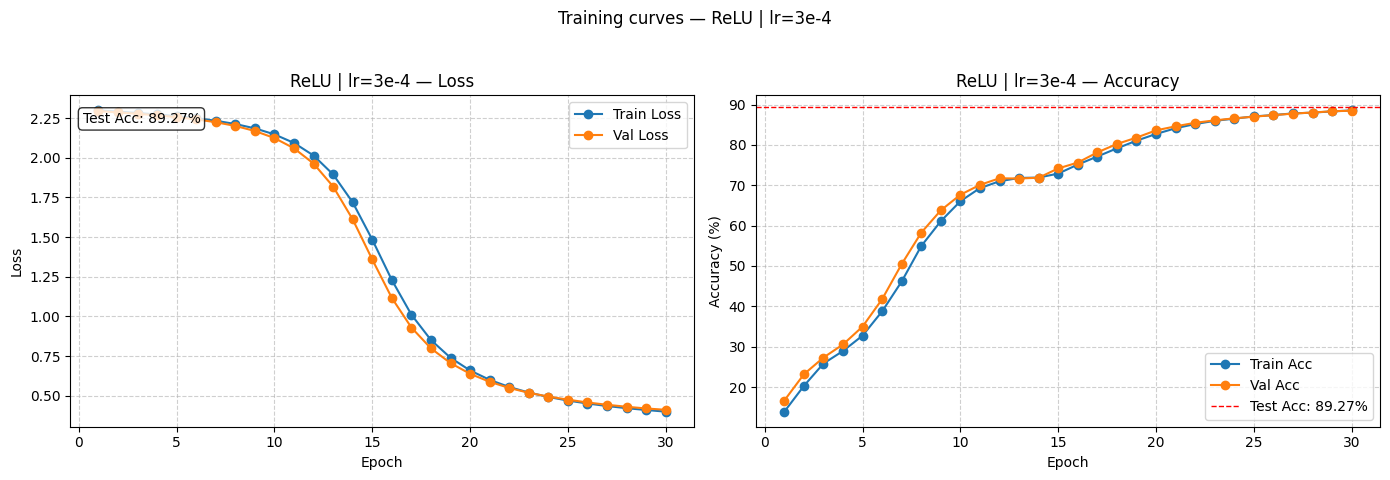

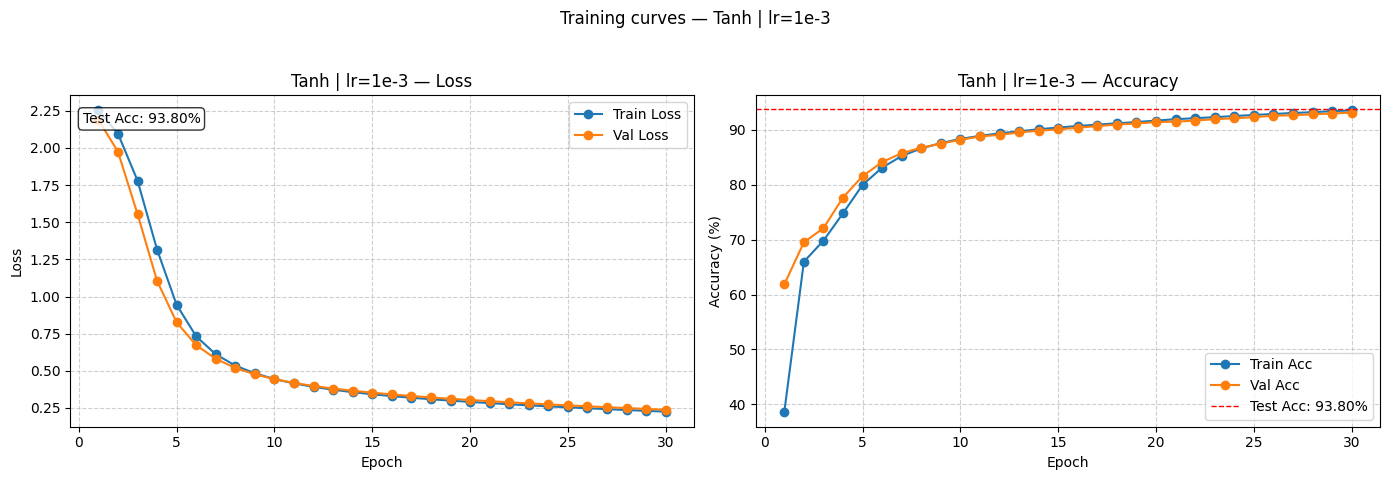

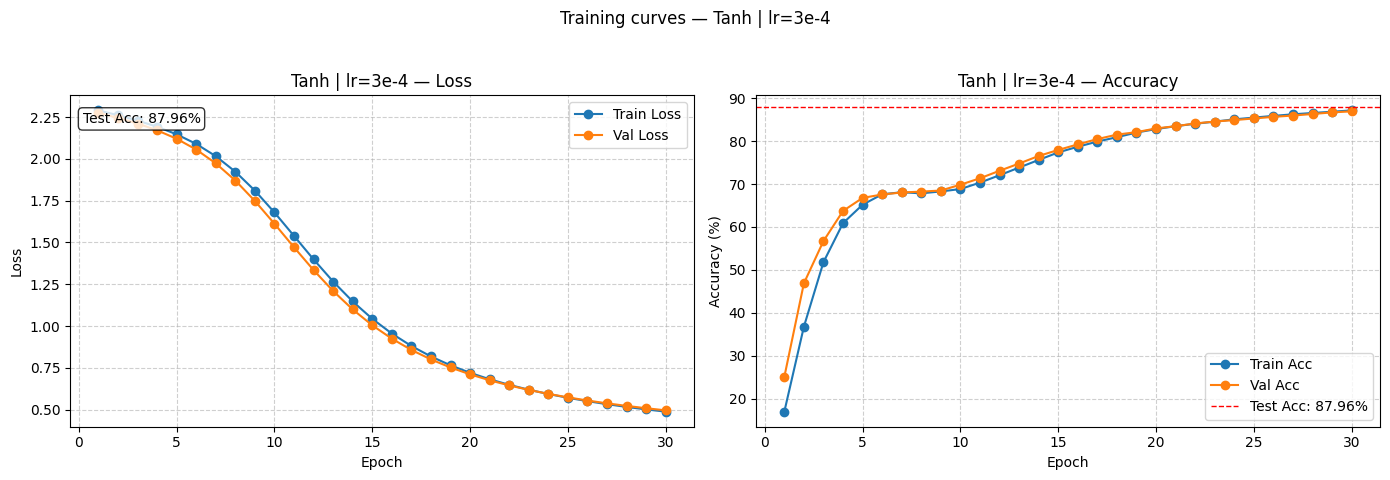

In [43]:
# Plots
def plot_results(config_name, results):
    """Plot train/validation loss and accuracy and annotate test accuracy.

    results: dict with keys 'train_loss','val_loss','train_acc','val_acc','test_acc'
    """
    epochs = len(results["train_loss"])
    x = list(range(1, epochs + 1))

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    axes[0].plot(x, results["train_loss"], label="Train Loss", marker='o')
    axes[0].plot(x, results["val_loss"], label="Val Loss", marker='o')
    axes[0].set_title(f"{config_name} — Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].grid(True, linestyle='--', alpha=0.6)
    axes[0].legend()

    # Accuracy plot
    axes[1].plot(x, [a * 100 for a in results["train_acc"]], label="Train Acc", marker='o')
    axes[1].plot(x, [a * 100 for a in results["val_acc"]], label="Val Acc", marker='o')
    axes[1].set_title(f"{config_name} — Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy (%)")
    axes[1].grid(True, linestyle='--', alpha=0.6)
    axes[1].legend()

    # Annotate test accuracy
    test_acc = results.get("test_acc")
    if test_acc is not None:
        axes[1].axhline(test_acc, color='red', linestyle='--', linewidth=1, label=f"Test Acc: {test_acc:.2f}%")
        axes[1].legend()
        # also print on loss plot for visibility
        axes[0].text(0.02, 0.95, f"Test Acc: {test_acc:.2f}%", transform=axes[0].transAxes,
                    fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    fig.suptitle(f"Training curves — {config_name}")
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_results("ReLU | lr=1e-3", results_relu_1e3)
plot_results("ReLU | lr=3e-4", results_relu_3e4)
plot_results("Tanh | lr=1e-3", results_tanh_1e3)
plot_results("Tanh | lr=3e-4", results_tanh_3e4)

  
2. **Write a short discussion:** (~1 page) reflecting on:
   - Which **activations/learning rates** choices performed best and why?
   - Any signs of over/underfitting you observed.

Note: Please upload the discussion write-ups of all sections of **Part 3** as a single PDF file on Gradescope.